# practicalMixGaussB

The goal of this part of the lab is to fit a mixture of gaussians model to some one-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

You should use this template for your code and fill in the missing 
sections marked "TO DO."

PLEASE NOTE (again): You should NOT be using functions like multivariate_normal.pdf and normfit or any other numpy functions for fitting your distributions in this or further parts of this practical. Optionally, you can try comparing your results to those produced by those functions, but our goal here is to learn what is happening!

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm
import random
import time

%matplotlib inline

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the mixtures of Gaussians as a python dictionary. Not that we are working in one dimension, but if we were to require $d$ dimenisions, the mean field would be a $d \times k$ matrix and the cov field would be a $d \times d \times k$ matrix. 

In [2]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 2 # number of gaussians
mixGaussTrue['d'] = 1 # dimension of the data
mixGaussTrue['weight'] = np.array([0.3, 0.7]) # weight assigned to each gaussian
mixGaussTrue['mean'] = np.array([[-1,1.5]]) # the mean for each gaussian 
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2)) # the covariance for each gaussian

print(mixGaussTrue['k'])
print(mixGaussTrue['d'])
print(mixGaussTrue['weight'])
print(mixGaussTrue['mean'])
print(mixGaussTrue['cov'])

2
1
[0.3 0.7]
[[-1.   1.5]]
[[[0.5  0.25]]]


**getGaussProb**, **sampleFromDiscrete**, and **drawEMData1d** are helper functions. 

In [3]:
# subroutine to return gaussian probabilities
def getGaussProb(x,mean,var):   
    """
    Returns the likelihood that each data point in x belongs to the Gaussian described by mean and 
    var.
    
    Keyword arguments:
    x -- 1 by n vector of data points. n is the number of data points.
    mean -- scalar containing the mean parameter of the Gaussian distribution.
    var -- scalar containing the variance parameter of the Gaussian distribution.
    
    Returns: 
    prob -- scalar contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by mean and var.
    """
    mean = np.squeeze(mean)                                        
    var = np.squeeze(var)                                          
    prob = np.exp(-0.5*((x-mean)**2)/(var))                        
    prob = prob/ np.sqrt(2*np.pi*var)                              
    return prob                                                    

In [4]:
def sampleFromDiscrete(probDist): 
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """

    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [5]:
def drawEMData1d(data, mixGauss):
    """
    Draw the data, data, in histogram form and plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- 1 by n vector of data points.
    mixGauss -- dict with mixture of gaussian information.

    """
    # delete previous plot if it exists                                                                   
    # hold off;                                                                                           
    # bin the data to make a histogram                                                                    
                                                                                                          
    binWidth = 0.1;                                                                                       
    binMin = -4.0;                                                                                        
    binMax = 4.0;                                                                                         
    nSteps = int(np.ceil((binMax - binMin) / binWidth))                                                   
                                                                                                          
    nDims, nData = data.shape                                                                             
                                                                                                          
    xHist = np.linspace(binMin, binMax, nSteps, endpoint=True)                                            
    xHistExt = np.append(xHist, np.inf)                                                                   
    yHist, _ = np.histogram(data, xHistExt)                                     
                                                                                                          
    yHist = yHist / (nData * binWidth)                                                                    
    plt.cla()                                                                                     
    plt.bar(xHist, yHist, binWidth, edgecolor='b')                                                        
                                                                                                          
    # calculate Gaussian data                                                                             
    nGauss = mixGauss['k']                                                                                
    gaussEnvEst = np.zeros(xHist.shape)                                                                   
    for cGauss in range(nGauss):                                                                          
        # calculate weighted Gaussian values                                                              
        gaussProb = mixGauss['weight'][cGauss] * getGaussProb(xHist, mixGauss['mean'][:,cGauss],          
                                                              mixGauss['cov'][:, :, cGauss])              
        plt.plot(xHist, gaussProb, 'm-')  # weighted components of MoG                                    
        # add to form envelope                                                                            
        gaussEnvEst = gaussEnvEst + gaussProb                                                             
                                                                                                          
    plt.plot(xHist, gaussEnvEst, 'g-')  # final mixture of Gaussians                                      
                                                                                                          
    # tidy up plot                                                                                        
    plt.xlabel('Data Value')                                                                              
    plt.ylabel('Probability Density')                                                                     
    # set(gca,'Box','Off');                                                                               
    # set(gcf,'Color',[1 1 1]);                                                                           
    plt.xlim((binMin, binMax))                                                                            
    plt.ylim((0, max(yHist) * 1.5))                                                                       
                                                                                                          
    return                                                                                                
    

**TODO D HERE:**

Complete the TO DO in this function before moving on. 



In [6]:
def mixGaussGen1d(mixGauss, nData):  
    """
    Generates data from a one-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- 1 by nData, generated data points. 
    """
    
    # create space for output data                                                                               
    data = np.zeros(shape=(1, nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):
        
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])
        
        # draw a sample from the appropriate Gaussian distribution 

        
        sample = np.random.normal(mixGauss.get('mean')[0][h], mixGauss.get('cov')[0][0][h],1)
        #print(sample)
            
        # TO DO (d)- replace this 
        data[:, cData] = sample
        
                                                                                                         
    return data                                                                                                  

With all the helper functions complete, we can now generate and plot some points from our model. The blue bars are the histogram of the generated points. The green curve is what the complete mixture of gaussians model looks like. The pink curves are the component gaussians. 

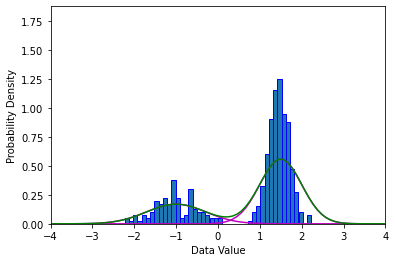

In [7]:
# define number of samples to generate
nData = 400;

#generate data from the mixture of Gaussians
#make sure you've filled out the todo above! 
data = mixGaussGen1d(mixGaussTrue,nData)

#print(data)

#plot! 
fig,ax = plt.subplots(1,1)
drawEMData1d(data,mixGaussTrue)

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO E HERE:** 

Fill out the missing parts below. 

In [8]:
def getMixGaussBound(data, mixGaussEst, responsibilities):                                                  
    """
    Calculate the bound on the log likelihood for the whole data set under a mixture of Gaussians model.  
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.
    responsibilities -- k by n vector containing the responsibility of this data point for each Gaussian. 
    
    Returns: 
    bound -- scalar containing the bound on the log likelihood.
    
    """
    # find total number of data items                                                                       
    nDims, nData = data.shape                                                                               
                                                                                                            
    # initialize bound                                                                                      
    bound = 0                                                                                               
    
        
    i = -1
    # run through each data item                                                                            
    for cData in range(data.shape[1]):
        i += 1
        # extract this data                                                                                 
        thisData = data[:, cData]
        
        # extract this q(h)                                                                                 
        thisQ = responsibilities[:, cData]                                                                  
                                                                                                            
        # TO DO (e) - calculate contribution to bound of this datapoint                                         
        # Replace this                                                                                      
        boundValue = 0
        
        for k in range(0,mixGaussEst.get('k')):
            
            l = mixGaussEst.get('weight')[k]
            norm = getGaussProb(thisData,mixGaussEst.get('mean')[0][k],mixGaussEst.get('cov')[0][0][k])[0]
            #r = responsibilities[k][i]
            r = thisQ[k]
            boundValue += r*np.log((l*norm)/r)
            
        # add to total log like                                                                             
        bound = bound + boundValue
                                                                                                            
    return np.asscalar(np.array(bound))                                                                          

**TODO F HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision. 

In [9]:
def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                                                                                             
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(data.shape[1]):
        
        thisData = data[:, cData]    
        
        # TO DO (f) - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0
        for k in range(0,mixGaussEst.get('k')):
            l = mixGaussEst.get('weight')[k]
            norm = getGaussProb(thisData,mixGaussEst.get('mean')[0][k],mixGaussEst.get('cov')[0][0][k])[0]
            like += l*norm   
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  np.asscalar(np.array(logLike))                                                                       
                                                                                                       

In [10]:
def E_step(responsibilities,mixGaussEst,data):
    
    curCov = mixGaussEst['cov']                                                                             
    curWeight = mixGaussEst['weight']                                                                            
    curMean = mixGaussEst['mean']
    
    l = np.zeros((mixGaussEst.get('k'),data.shape[1]),dtype=np.float64)
    r = np.zeros((mixGaussEst.get('k'),data.shape[1]),dtype=np.float64)
    
    #print("Created Responsibilities shape: " + str(r.shape))
    
    #print(l.shape)
    #print(r.shape)
    
    # TO DO: fill in column of 'hidden' - caculate posterior probability that                                
    # this data point came from each of the Gaussians                                                        
    # replace this:
    
    i = -1
    for cData in range(data.shape[1]):
        i += 1
        
        thisData = data[:, cData] 
        
        sum_l = 0
        for k in range(0,mixGaussEst.get('k')):
            
            norm = getGaussProb(thisData,mixGaussEst.get('mean')[0][k],mixGaussEst.get('cov')[0][0][k])
            ll = mixGaussEst.get('weight')[k]*norm
            l[k][i] = ll[0]
            sum_l += l[k][i]
        
        for k in range(0,mixGaussEst.get('k')):
            r[k][i] = l[k][i]/sum_l
                                                                                                
    return r

In [11]:
def M_step(k,mixGaussEst,responsibilities,data):
    
    #print(mixGaussEst)
    
    # ===================== =====================                                                                
    # Maximization Step                                                                                          
    # ===================== =====================  
    
    #new_weights = np.zeros(mixGaussEst.get('weight').shape[0],dtype=np.float64)
    #mew_mean = np.zeros(mixGaussEst.get('mean')[:].shape,dtype=np.float64)
    #new_cov = np.zeros(mixGaussEst.get('cov')[:][:].shape,dtype=np.float64)
    
    #print(new_weights)
    #print(mew_mean)
    #print(new_cov)
    
    # for each latent variable refered to each Gaussian                                                                              
    for cGauss in range(k):
        
        r = 0
        for i in range(data.shape[1]):
            r += responsibilities[cGauss][i]
            
            
        # TO DO:  Update weighting parameters mixGauss.weight based on the total                                 
        # posterior probability associated with each Gaussian. Replace this:                                         
        
    
        sum_l = 0
        for kk in range(k):
            for ii in range(data.shape[1]):
                sum_l += responsibilities[kk][ii]
                    
                    
        #new_weights[cGauss] = sum_l
        
        #print(sum_l)
        
        mixGaussEst['weight'][cGauss] = r/sum_l
                    
            
        # TO DO:  Update mean parameters mixGauss.mean by weighted average                                       
        # where weights are given by posterior probability associated with                                       
        # Gaussian. 
        
        i = -1
        sum_m = 0
        for cData in range(data.shape[1]):
            i += 1
            
            thisData = data[:, cData]
            sum_m += (responsibilities[cGauss][i]*thisData)      
            
        #mew_mean[0][cGauss] = sum_m
        
        #print(sum_m)
        
        mixGaussEst['mean'][:,cGauss] = sum_m/r
        
            
            
        # TO DO:  Update covarance parameter based on weighted average of                                        
        # square distance from update mean, where weights are given by                                           
        # posterior probability associated with Gaussian
        
        
        i = -1
        sum_s = 0
        for cData in range(data.shape[1]):
            i += 1
            
            thisData = data[:, cData]
            
            new_mean = mixGaussEst['mean'][:,cGauss]
            
            mu_matrix = (thisData - new_mean)**2
            sum_s += (responsibilities[cGauss][i]*mu_matrix)
        
        mixGaussEst['cov'][:,:,cGauss] = sum_s/r
            
    return mixGaussEst

**TODO G HERE:** 

Fill out the missing parts below. 

In [12]:
def fitMixGauss1d(data, k):
    
    #print(data.shape)
    #print(k)
    #return

    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape                                                                                        
                                                                                                                     
                                                                                                      
    responsibilities = np.zeros(shape=(k, nData))
                                                                                                                     
    # we will initialize the values to random values                                                                 
    mixGaussEst = dict()                                                                                             
    mixGaussEst['d'] = 1                                                                                             
    mixGaussEst['k'] = k                                                                                             
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))                                                             
    mixGaussEst['mean'] = 2 * np.random.randn(1, k)                                                                  
    mixGaussEst['cov'] = 0.1 + 1.5*np.random.uniform(size=(1,1,2))
    
    print("Initial Parameters: " + str(mixGaussEst))
    
    
    #print(responsibilities.shape)
    #return 

    # calculate current likelihood                                                                                   
    # TO DO (g) starts here- fill in this routine                                                                                   
    logLike = getMixGaussLogLike(data, mixGaussEst)                                                                  
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
                                                                                                            
    nIter = 20;                                                                                                      
                                                                                                                     
    logLikeVec = np.zeros(shape=(2 * nIter))                                                                         
    boundVec = np.zeros(shape=(2 * nIter)) 
    
    fig,ax = plt.subplots(1,1)
                                                                                                                     
    for cIter in range(nIter):                                                                                       
                                                                                                                     
        # ===================== =====================                                                                
        # Expectation step                                                                                           
        # ===================== =====================
        
        #print("Responsibilities before: " + str(responsibilities.shape))
        #print(responsibilities)
        responsibilities = E_step(responsibilities,mixGaussEst,data)
        #print("Responsibilities after: " + str(responsibilities.shape))
        #print(responsibilities)
        
        #return
        
        #print(data)
        #print(mixGaussEst)

        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                              
        print('Log Likelihood After E-Step Iter {} : {:4.3f}\n'.format(cIter, logLike))                              
                                                                                                                     
        # calculate the bound                                                                                        
        # TO DO - Fill in this routine                                                                               
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        print('Bound After E-Step Iter {} : {:4.3f}\n'.format(cIter, bound))
        
        logLikeVec[2 * cIter] = logLike                                                                              
        boundVec[2 * cIter] = bound
        
        ### maximisation step
        ## update distributions based on the new responsibilities
        
        mixGaussEst = M_step(k,mixGaussEst,responsibilities,data)
        
        
        print(mixGaussEst)
        
                                                                                                              
        # draw the new solution  
        drawEMData1d(data, mixGaussEst)
        time.sleep(3)
        fig.canvas.draw()
                                                                                                                     
        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                              
        print('Log Likelihood After M-Step Iter {} : {:4.3f}\n'.format(cIter, logLike))                              
                                                                                                                     
        # calculate the bound                                                                                        
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        print('Bound After M-Step Iter {} : {:4.3f}\n'.format(cIter, bound)) 
                                                                                                                  
        logLikeVec[2 * cIter + 1] = logLike                                                                          
        boundVec[2 * cIter + 1] = bound
        
        #return
                                                                                                                     
    plt.figure()                                                                                                     
    plt.plot(logLikeVec, 'g',label='log likelihood')                                                                                        
    plt.plot(boundVec, 'r',label='upper bound')  
    plt.legend()
                                                                                                                     
    return mixGaussEst                                                                                               

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

Initial Parameters: {'d': 1, 'k': 2, 'weight': array([0.5, 0.5]), 'mean': array([[3.94886892, 1.52197327]]), 'cov': array([[[1.27864805, 0.39278868]]])}
Log Likelihood Iter 0 : -1442.190

Log Likelihood After E-Step Iter 0 : -1442.190

Bound After E-Step Iter 0 : -1442.190

{'d': 1, 'k': 2, 'weight': array([0.09932632, 0.90067368]), 'mean': array([[-0.17180498,  0.84492183]]), 'cov': array([[[2.48698173, 1.20548006]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 0 : -636.139

Bound After M-Step Iter 0 : -644.079

Log Likelihood After E-Step Iter 1 : -636.139

Bound After E-Step Iter 1 : -636.139

{'d': 1, 'k': 2, 'weight': array([0.10711198, 0.89288802]), 'mean': array([[-0.32648726,  0.8723432 ]]), 'cov': array([[[1.80054065, 1.22628368]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 1 : -633.768

Bound After M-Step Iter 1 : -634.657

Log Likelihood After E-Step Iter 2 : -633.768

Bound After E-Step Iter 2 : -633.768

{'d': 1, 'k': 2, 'weight': array([0.11718255, 0.88281745]), 'mean': array([[-0.48082269,  0.90650465]]), 'cov': array([[[1.5723574 , 1.18017953]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 2 : -631.397

Bound After M-Step Iter 2 : -632.750

Log Likelihood After E-Step Iter 3 : -631.397

Bound After E-Step Iter 3 : -631.397

{'d': 1, 'k': 2, 'weight': array([0.13077634, 0.86922366]), 'mean': array([[-0.6530516 ,  0.95411323]]), 'cov': array([[[1.32361407, 1.10274343]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 3 : -626.625

Bound After M-Step Iter 3 : -629.466

Log Likelihood After E-Step Iter 4 : -626.625

Bound After E-Step Iter 4 : -626.625

{'d': 1, 'k': 2, 'weight': array([0.15034349, 0.84965651]), 'mean': array([[-0.84311226,  1.02475591]]), 'cov': array([[[0.9749338 , 0.98038811]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 4 : -614.589

Bound After M-Step Iter 4 : -621.985

Log Likelihood After E-Step Iter 5 : -614.589

Bound After E-Step Iter 5 : -614.589

{'d': 1, 'k': 2, 'weight': array([0.18043956, 0.81956044]), 'mean': array([[-1.0285471 ,  1.13417466]]), 'cov': array([[[0.53118463, 0.77810556]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 5 : -579.738

Bound After M-Step Iter 5 : -600.420

Log Likelihood After E-Step Iter 6 : -579.738

Bound After E-Step Iter 6 : -579.738

{'d': 1, 'k': 2, 'weight': array([0.22769137, 0.77230863]), 'mean': array([[-1.10486054,  1.28899415]]), 'cov': array([[[0.23963709, 0.46999076]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 6 : -512.507

Bound After M-Step Iter 6 : -543.681

Log Likelihood After E-Step Iter 7 : -512.507

Bound After E-Step Iter 7 : -512.507

{'d': 1, 'k': 2, 'weight': array([0.27508172, 0.72491828]), 'mean': array([[-1.05083563,  1.4249879 ]]), 'cov': array([[[0.21995652, 0.19644222]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 7 : -419.521

Bound After M-Step Iter 7 : -461.402

Log Likelihood After E-Step Iter 8 : -419.521

Bound After E-Step Iter 8 : -419.521

{'d': 1, 'k': 2, 'weight': array([0.30416417, 0.69583583]), 'mean': array([[-0.97873183,  1.49694685]]), 'cov': array([[[0.25423457, 0.07290062]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 8 : -347.564

Bound After M-Step Iter 8 : -362.483

Log Likelihood After E-Step Iter 9 : -347.564

Bound After E-Step Iter 9 : -347.564

{'d': 1, 'k': 2, 'weight': array([0.30999662, 0.69000338]), 'mean': array([[-0.95666583,  1.50795969]]), 'cov': array([[[0.2754466 , 0.05877644]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 9 : -343.958

Bound After M-Step Iter 9 : -343.996

Log Likelihood After E-Step Iter 10 : -343.958

Bound After E-Step Iter 10 : -343.958

{'d': 1, 'k': 2, 'weight': array([0.31010061, 0.68989939]), 'mean': array([[-0.95608746,  1.5080712 ]]), 'cov': array([[[0.27638472, 0.05868785]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 10 : -343.957

Bound After M-Step Iter 10 : -343.957

Log Likelihood After E-Step Iter 11 : -343.957

Bound After E-Step Iter 11 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.3101038, 0.6898962]), 'mean': array([[-0.95606766,  1.50807369]]), 'cov': array([[[0.27642026, 0.05868666]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 11 : -343.957

Bound After M-Step Iter 11 : -343.957

Log Likelihood After E-Step Iter 12 : -343.957

Bound After E-Step Iter 12 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606697,  1.50807377]]), 'cov': array([[[0.2764215 , 0.05868663]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 12 : -343.957

Bound After M-Step Iter 12 : -343.957

Log Likelihood After E-Step Iter 13 : -343.957

Bound After E-Step Iter 13 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 13 : -343.957

Bound After M-Step Iter 13 : -343.957

Log Likelihood After E-Step Iter 14 : -343.957

Bound After E-Step Iter 14 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 14 : -343.957

Bound After M-Step Iter 14 : -343.957

Log Likelihood After E-Step Iter 15 : -343.957

Bound After E-Step Iter 15 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 15 : -343.957

Bound After M-Step Iter 15 : -343.957

Log Likelihood After E-Step Iter 16 : -343.957

Bound After E-Step Iter 16 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 16 : -343.957

Bound After M-Step Iter 16 : -343.957

Log Likelihood After E-Step Iter 17 : -343.957

Bound After E-Step Iter 17 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 17 : -343.957

Bound After M-Step Iter 17 : -343.957

Log Likelihood After E-Step Iter 18 : -343.957

Bound After E-Step Iter 18 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 18 : -343.957

Bound After M-Step Iter 18 : -343.957

Log Likelihood After E-Step Iter 19 : -343.957

Bound After E-Step Iter 19 : -343.957

{'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/apostolos/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Log Likelihood After M-Step Iter 19 : -343.957

Bound After M-Step Iter 19 : -343.957

Final Gaussian Mixture: {'d': 1, 'k': 2, 'weight': array([0.31010391, 0.68989609]), 'mean': array([[-0.95606695,  1.50807377]]), 'cov': array([[[0.27642154, 0.05868662]]])}


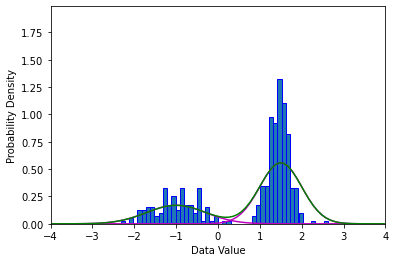

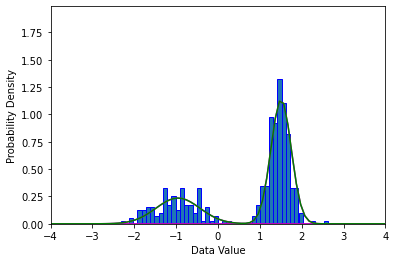

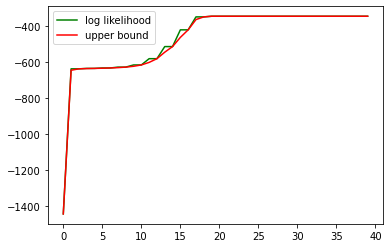

In [13]:
#generate data from the ground truth mixture of Gaussians we've defined way above. 
#make sure you've completed this routine above.
data = mixGaussGen1d(mixGaussTrue,nData);

#draw data, ground truth mixture of Gaussians.
drawEMData1d(data,mixGaussTrue)

#print(mixGaussTrue)

#define number of components to estimate
nGaussEst = 2;

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#Make sure you've completed this routine above.
mixGaussEst = fitMixGauss1d(data,nGaussEst);
#plt.show()

print("Final Gaussian Mixture: " + str(mixGaussEst))